# 3 Qubit Error Correcting Code

### In this nnotebook we will introduce the 3 qubit code and demonstrate how it works as well as create a running example. We will only use numpy to derive the math as well as create the algorithm, while qiskit will only be used to draw the circuits so that we are able to visualize them.

In [1]:
# Importing required libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace
import numpy as np
import random
from numpy.linalg import inv
import matplotlib.pyplot as plt
from qiskit.extensions import UnitaryGate

# For creating tables:
from tabulate import tabulate
from prettytable import PrettyTable

# Initialize backends simulators to visualize circuits
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')


env: QISKIT_SETTINGS={}


#### Below we show the Pauli Operators which can be used to describe any quantum gate on an individual qubit

In [2]:
# Initializing the Pauli operators
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,1j],[-1j,0]])
sigma_z = np.array([[1,0],[0,-1]])
sigma_I = np.identity(2)
print('Pauli-X: \n', sigma_x) 
print('Pauli-Y: \n', sigma_y)
print('Pauli-Z: \n', sigma_z)
print('Pauli-I: \n', sigma_I)

Pauli-X: 
 [[0 1]
 [1 0]]
Pauli-Y: 
 [[ 0.+0.j  0.+1.j]
 [-0.-1.j  0.+0.j]]
Pauli-Z: 
 [[ 1  0]
 [ 0 -1]]
Pauli-I: 
 [[1. 0.]
 [0. 1.]]


## Initializing the 3-qubit logical state
#### The 3 Qubit code is the most basic algorithm used for quantum error correction. However, it does not actually represent a full quantum code since it cannot simultaneously correct for bit flips and phase flips.
#### In this algorithm a single logical qubit is encoded using 3 physical qubits, and it is able to correct for a single $\sigma_x$ error (bit flip). This is like having a sort of 'repeater' that has the information encoded multiple times so that if errors do occur in a single physical qubit, we are able to see them and (hopefully) correct for them.

#### In this case we will define our two logical states as $\vert0\rangle_L$ and $\vert1\rangle_L$ where $\vert0\rangle_L = \vert000\rangle$ and $\vert1\rangle_L = \vert111\rangle$

#### Thus a single qubit state will be represented by $\vert\psi\rangle_L = \alpha\vert0\rangle_L + \beta\vert1\rangle_L$

#### Below we show the quantum circuit for encoding a single logical qubit. Here we use two ancilla qubits initialized to $\vert0\rangle$ and two CNOT gates.

#### CNOT gates can be represented with the matrix below and it performs an operation on two qubits. One being the target qubit and the other the control. Basically, if the control is $\vert0\rangle$ then nothing happens, but if the control is $\vert1\rangle$ then the target qubit switches states, either to a $\vert0\rangle$ or $\vert1\rangle$

#### CNOT gate matrix representation:  $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}$$


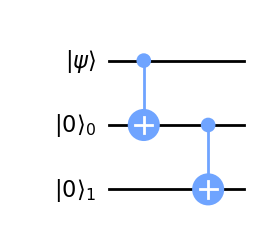

In [3]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(2, '|0⟩')
qc = QuantumCircuit(psi, ancilla)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.draw()

#### Mathematically we are able to show what this would look like in terms of matrices and vectors. Our operation will look something like:
$$ CNOT_{\psi, 0} CNOT_{0, 1} \vert\psi\rangle \vert0\rangle_0 \vert0\rangle_0 = CNOT_{\psi, 0} CNOT_{0, 1} \vert\psi 0_0 0_1\rangle$$
#### Where $CNOT_{\psi, 0}$ is the CNOT operation with qubit $\vert0\rangle_0$ as the target and qubit $\vert\psi\rangle$ as the control, and $CNOT_{0, 1}$ is the CNOT operation with qubit $\vert1\rangle_0$ as teh target and qubit $\vert0\rangle_0$ as the control. $\vert\psi\rangle$, $\vert0\rangle_0$, and $\vert0\rangle_1$ are the initial states for the three qubits respectively.
#### Operations on multiple qubits: https://learn.microsoft.com/en-us/azure/quantum/concepts-multiple-qubits
#### In order to achieve this initialization we need to derive two operators (the CNOT gates). Although they are the same gate, the operators themselves will look slightly different due to the fact that our qubit $\vert\psi\rangle$ is acting on qubit $\vert0\rangle_0$, and $\vert0\rangle_0$ is acting on qubit $\vert0\rangle_1$. We know that the dimensions of our operations $CNOT_{\psi, 0}$ and  $CNOT_{0, 1}$ should be 8 x 8 matrices. This is due to the fact that $\vert\psi 0_0 0_1\rangle$ is an 8 x 1 vector and we want to arrive at a vector of the same dimension in the end.

#### Thus for the first CNOT on $\vert0\rangle_0$ we know that the operation should not affect qubit $\vert0\rangle_1$. Therefore we know that $CNOT_{\psi, 0} = CNOT \otimes I_2$ where CNOT is our usual CNOT operation between $\vert\psi\rangle$ and $\vert0\rangle_0$ defined above and $I_2$ is the 2 x 2 identity matrix for $\vert0\rangle_1$. Also $CNOT_{0, 1} = I_2 \otimes CNOT$ where CNOT is our usual CNOT operation between $\vert0\rangle_0$ and $\vert0\rangle_1$ defined above and $I_2$ is the 2 x 2 identity matrix for $\vert\psi\rangle_1$. Thus 

$$CNOT_{\psi, 0} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0
\end{pmatrix},\quad and \quad
CNOT_{0, 1} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{pmatrix}$$

#### Below is an implementation of the 3-qubit code shown in the circuit above for initializing the logical state of the system


In [4]:
# Used to perform a CNOT gate on 2 adjacent qubits (i.e. |psi> and |q_0>)
cnot = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0]])

In [5]:
### Initializes the three qubit logical state using an initial single qubit psi ###
def three_qubit_initialize_logical_state(initial_psi):
    # initial_psi: initial state of your single qubit that you want to use as your logical state (2 x 1)
    
    initial_ancilla_state = np.array([1,0]) # initializing the |0> state of the qubits
    
    # Initialize the 3 qubit logical state by using thr kronecker product
    initial_logical_state = np.kron(initial_psi, np.kron(initial_ancilla_state, initial_ancilla_state))

    # Setting up the 2 CNOT gates to initialize the correct logical qubit
    cnot_psi_qzero = np.kron(cnot, np.identity(2))
    cnot_qzero_qone = np.kron(np.identity(2), cnot)
    
    # Apply the CNOT gates to the kronecker product of the current 3 qubit state
    final_logical_state = np.dot(cnot_qzero_qone, np.dot(cnot_psi_qzero, initial_logical_state))
    
    return final_logical_state, psi, initial_logical_state


# Print the initial and final logical state, try to convince yourself that this makes sense
final_logical_state, psi, initial_logical_state = three_qubit_initialize_logical_state(np.array([0,1]))
print('Psi State: ', psi)
print('Initial Logical State: ', initial_logical_state)
print('Final Logical State: ', final_logical_state.astype(int))


Psi State:  QuantumRegister(1, '|ψ⟩')
Initial Logical State:  [0 0 0 0 1 0 0 0]
Final Logical State:  [0 0 0 0 0 0 0 1]


## Encoding and correcting for a single X error
#### One thing to note about the circuit above is that three bit flips are required to encode a single qubit. This number is defined as the distance between two codeword states and is given the variable d. With this we are able to calculate the number of errors that can be corrected:
$$ t = \left\lfloor \frac{(d-1)}{2} \right\rfloor$$
#### In the case of the 3 qubit code, we can see that d = 3 and thus t = 1

#### Now in order to actually be able to correct for errors we require two more ancilla qubits to obtain information about possible errors (syndrome information) without directly measuring the exact state of any of the qubits in the logical qubit.
#### Our new circuit will now look like this:

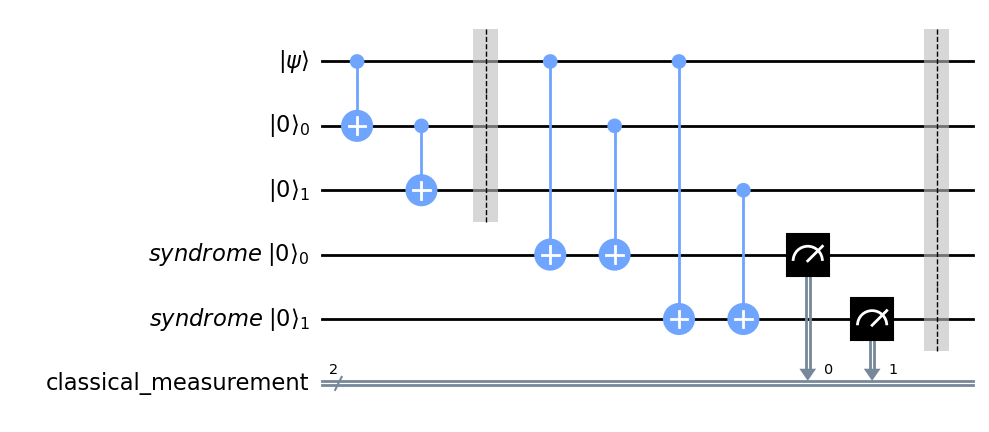

In [6]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(2, '|0⟩')
syndrome_ancilla = QuantumRegister(2, 'syndrome |0⟩')
classical_bits = ClassicalRegister(2, 'classical_measurement')
qc = QuantumCircuit(psi, ancilla, syndrome_ancilla, classical_bits)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.barrier(0,1,2) # A bit flip error occurs here
qc.cnot(0, 3)
qc.cnot(1, 3)
qc.cnot(0, 4)
qc.cnot(2, 4)
qc.measure(syndrome_ancilla, classical_bits)
qc.barrier()
qc.draw()

#### The first dashed line represents the bit flip (X) error that occurs to any of the first 3 data qubits. After that we apply 4 CNOT gates to obtain the error information. Then we classically measure the syndrome qubits to see if an error occured and where the error is. 

#### In this example we assume that the error only occurs where the dashed line is and all other gate operations are 'perfect'. Additionally we assume that only a single bit flip error occurs.

#### Now we will simulate what would happen if a single X bit flip error occurs at a random location after we have initialized the 3 qubit logical state. We can mathematically represent each errror at a location as the following:

#### If the error occurs at the 0th qubit ($\vert\psi\rangle$): $(X \otimes I_2 \otimes I_2)\vert\psi q_1 q_2 \rangle$
#### If the error occurs at the 1st qubit ($\vert q_1\rangle$): $(I_2 \otimes X \otimes I_2)\vert\psi q_1 q_2 \rangle$
#### If the error occurs at the 2nd qubit ($\vert q_2\rangle$): $(I_2 \otimes I_2 \otimes X)\vert\psi q_1 q_2 \rangle$
#### Where X is the Pauli-x ($\sigma_x$) operator

In [7]:
### Applies a random X rotation to one of the three physical qubits in your system (randomly) ###
def three_qubit_random_qubit_x_error(logical_state):
    # logical_state: The logical state of the three qubit system you wish to apply the error to (8 x 1)
    
    # Choose the index of the qubit you want to apply the error to.
    error_index = random.randint(-1,2)
    # Apply the error to the qubit (no error may occur)
    if error_index == 0:
        errored_logical_state = np.dot(np.kron(sigma_x, np.identity(4)), logical_state)
    elif error_index == 1:
        errored_logical_state = np.dot(np.kron(np.kron(np.identity(2), sigma_x), np.identity(2)), logical_state)
    elif error_index == 2:
        errored_logical_state = np.dot(np.kron(np.identity(4), sigma_x), logical_state)
    else:
        errored_logical_state = logical_state
        
    return errored_logical_state, error_index


### Applies an X rotation to one of the three physical qubits in your system (your choice for which qubit is errored) ###
def three_qubit_defined_qubit_x_error(logical_state, error_index):
    # logical_state: The logical state of the three qubit system you wish to apply the error to (8 x 1)
    # error_index: Which qubit you want the error to occur.
    
    # Apply the error to the qubit (no error may occur)
    if error_index == 0:
        errored_logical_state = np.dot(np.kron(sigma_x, np.identity(4)), logical_state)
    elif error_index == 1:
        errored_logical_state = np.dot(np.kron(np.kron(np.identity(2), sigma_x), np.identity(2)), logical_state)
    elif error_index == 2:
        errored_logical_state = np.dot(np.kron(np.identity(4), sigma_x), logical_state)
    else:
        errored_logical_state = logical_state
        
    return errored_logical_state, error_index

# Print out the errored logical state and the index qubit which the error occured (using the final state from before)
state, qubit_errored = three_qubit_random_qubit_x_error(final_logical_state)
print('Logical State without the random X error: ', final_logical_state.astype(int))
print('Logical Satte with the random X error: ', state.astype(int))
print('The Error occured at qubit: ', qubit_errored)

Logical State without the random X error:  [0 0 0 0 0 0 0 1]
Logical Satte with the random X error:  [0 0 0 0 0 1 0 0]
The Error occured at qubit:  1


### Next we need to be able to find where the qubit errored without directly knowing where it errored (kind of counter intuitive). Since this is a simulation we are able to print out what index the qubit actaully errored at to check our work, but in reality we wont know. So we should have a way to determine this. That is where our syndrome ancilla qubits come into play. They will tell us where our error occured!

#### Below we derive each CNOT gate represented in the ciruit above as a 32 x 32 matrix. Since the matrix is too large to show, we can follow a different process to deriving the CNOT gates than we did earlier for the logical state initialization. 

#### We will be using the following derivation method for a CNOT gate with one qubit in between the control and target qubits (thus the qubits that the gate acts on are non-adjacent). For this CNOT gate it is not so simple, like our previous derivation for a 3-qubit CNOT since there is no known kronecker product that would lead to the transformation needed. Thus we can derive it by looking at what happens to the logical states of the qubit when we apply this gate.
https://quantumcomputing.stackexchange.com/questions/4252/how-to-derive-the-cnot-matrix-for-a-3-qubit-system-where-the-control-target-qu/4254#4254

$$ CNOT\vert000\rangle \to \vert000\rangle = [1 0 0 0 0 0 0 0 ]^T\\ CNOT\vert001\rangle \to \vert001\rangle = [0 1 0 0 0 0 0 0 ]^T \\
CNOT\vert010\rangle \to \vert010\rangle = [0 0 1 0 0 0 0 0 ]^T\\ CNOT\vert011\rangle \to \vert011\rangle = [0 0 0 1 0 0 0 0 ]^T \\
CNOT\vert100\rangle \to \vert101\rangle = [0 0 0 0 0 1 0 0 ]^T\\ CNOT\vert101\rangle \to \vert100\rangle = [0 0 0 0 1 0 0 0 ]^T \\
CNOT\vert110\rangle \to \vert111\rangle = [0 0 0 0 0 0 0 1 ]^T\\ CNOT\vert111\rangle \to \vert110\rangle = [0 0 0 0 0 0 1 0 ]^T $$

#### Now if you look closely when we put these together as the collumns of out matrix we get:


$$ CNOT_{\psi, 1} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{pmatrix}$$

#### Which is the matrix representation for the CNOT gate when our 2 qubits are not adjacent in the 3-qubit system.

## Deriving the qubit gates for the Circuit above:
#### For the first CNOT gate, we can see that there are 2 qubits in between the control and target qubits. Thus we need to use the second method when we derived the CNOT for non-adjacent qubits, only this time we have 5 qubits to keep track of. But we do not actually need to compute 32 states of the qubit. If we notice that the first 16 transformations will do nothing to our state since the first qubit is in the $\vert0\rangle$ state. Thus we only need to change the last 16 columns. We can compute the transformations that occur and set the new tensor products of the qubit states as the columns of our matrix. (again this is the same process as deriving the non-adjacent CNOT, just with more qubits)

In [8]:
# Used to perform a CNOT gate on 2 non-adjacent qubits (i.e. |psi> and |q_1>)
def non_adjacent_qubit_cnot():
    cnot = np.identity(8)
    cnot[4:] = 0
    cnot[4][5] = 1
    cnot[5][4] = 1
    cnot[7][6] = 1
    cnot[6][7] = 1
    return cnot

In [9]:
# Finding the matrix operation for first cnot gate after the error occurs in the circuit above
np.set_printoptions(threshold=np.inf)
zero = np.array([1, 0])
one = np.array([0, 1])
def first_cnot():
    matrix = np.identity(32)
    matrix[:][16] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, zero))))
    matrix[:][17] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, one))))
    matrix[:][18] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(zero, zero))))
    matrix[:][19] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(zero, one))))
    matrix[:][20] = np.kron(one, np.kron(zero, np.kron(one, np.kron(one, zero))))
    matrix[:][21] = np.kron(one, np.kron(zero, np.kron(one, np.kron(one, one))))
    matrix[:][22] = np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, zero))))
    matrix[:][23] = np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, one))))
    matrix[:][24] = np.kron(one, np.kron(one, np.kron(zero, np.kron(one, zero))))
    matrix[:][25] = np.kron(one, np.kron(one, np.kron(zero, np.kron(one, one))))
    matrix[:][26] = np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, zero))))
    matrix[:][27] = np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, one))))
    matrix[:][28] = np.kron(one, np.kron(one, np.kron(one, np.kron(one, zero))))
    matrix[:][29] = np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))
    matrix[:][30] = np.kron(one, np.kron(one, np.kron(one, np.kron(zero, zero))))
    matrix[:][31] = np.kron(one, np.kron(one, np.kron(one, np.kron(zero, one))))
    return matrix

# Testing outputs
print(np.dot(first_cnot(), np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, zero))))).astype(int)) # applying CNOT
print(np.kron(one, np.kron(zero, np.kron(one, np.kron(one, zero))))) # Put state that it should be in after operation

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


#### For the second CNOT gate we notice that there is only one qubit in between the control and the target. Thus we can implement the non-adjacent CNOT gate and just tensor it with the Identity 2x2 matrix as shown below.
$$CNOT_{q_1, q_3} = I_2 \otimes CNOT_{non-adj} \otimes I_2$$

In [10]:
# Finding the matrix operation for second cnot gate after the error occurs in the circuit above
# For this we will be able to implement the non-adjacent CNOT gate that we derived earlier in the notebook
def second_cnot():
    matrix = np.kron(np.identity(2), np.kron(non_adjacent_qubit_cnot(), np.identity(2)))
    return matrix

# Testing outputs
print(np.dot(second_cnot(), np.kron(one, np.kron(one, np.kron(one, np.kron(one, zero))))).astype(int)) # applying CNOT
print(np.kron(one, np.kron(one, np.kron(one, np.kron(zero, zero))))) # Put state that it should be in after operation


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


#### For the third CNOT gate, we can see that there are 3 qubits in between the control and target qubits. Thus we need to use the second method when we derived the CNOT for non-adjacent qubits, only this time we have 5 qubits to keep track of. But we do not actually need to compute 32 states of the qubit. If we notice that the first 16 transformations will do nothing to our state since the first qubit is in the $\vert0\rangle$ state just like with the first CNOT we derived previously. Thus we only need to change the last 16 columns. We can compute the transformations that occur and set the new tensor products of the qubit states as the columns of our matrix. (again this is the same process as deriving the non-adjacent CNOT, just with more qubits)

In [11]:
# Finding the matrix operation for third cnot gate after the error occurs in the circuit above
np.set_printoptions(threshold=np.inf)
zero = np.array([1, 0])
one = np.array([0, 1])
def third_cnot():
    matrix = np.identity(32)
    matrix[:][16] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(zero, one))))
    matrix[:][17] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(zero, zero))))
    matrix[:][18] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, one))))
    matrix[:][19] = np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, zero))))
    matrix[:][20] = np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, one))))
    matrix[:][21] = np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, zero))))
    matrix[:][22] = np.kron(one, np.kron(zero, np.kron(one, np.kron(one, one))))
    matrix[:][23] = np.kron(one, np.kron(zero, np.kron(one, np.kron(one, zero))))
    matrix[:][24] = np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, one))))
    matrix[:][25] = np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, zero))))
    matrix[:][26] = np.kron(one, np.kron(one, np.kron(zero, np.kron(one, one))))
    matrix[:][27] = np.kron(one, np.kron(one, np.kron(zero, np.kron(one, zero))))
    matrix[:][28] = np.kron(one, np.kron(one, np.kron(one, np.kron(zero, one))))
    matrix[:][29] = np.kron(one, np.kron(one, np.kron(one, np.kron(zero, zero))))
    matrix[:][30] = np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))
    matrix[:][31] = np.kron(one, np.kron(one, np.kron(one, np.kron(one, zero))))
    return matrix

# Testing outputs
print(np.dot(third_cnot(), np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, zero))))).astype(int)) # applying CNOT
print(np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, one))))) # Put state that it should be in after operation


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


#### For the fourth CNOT gate we again notice that there is only one qubit in between the control and the target. Thus we can implement the non-adjacent CNOT gate and just tensor it with the Identity 2x2 matrix as shown below.
$$CNOT_{q_2, q_4} = I_2 \otimes CNOT_{non-adj} \otimes I_2$$

In [12]:
# Finding the matrix operation for fourth cnot gate after the error occurs in the circuit above
# For this we will be able to implement the non-adjacent CNOT gate that we derived earlier in the notebook
def fourth_cnot():
    matrix = np.kron(np.identity(4), non_adjacent_qubit_cnot())
    return matrix

# Testing outputs
print(np.dot(fourth_cnot(), np.kron(one, np.kron(one, np.kron(zero, np.kron(one, zero))))).astype(int)) # applying CNOT
print(np.kron(one, np.kron(one, np.kron(zero, np.kron(one, zero))))) # Put state that it should be in after operation


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


### Instead of using the tedious methods from above everytime we want to find a CNOT gate between 2 non-adjacent qubits, the following function was created to make a matrix representation of a non-adjacent CNOT gate

#### Below I construct a function to create a non-adjacent CNOT gate for any number of qubits in between the control and target. The reference I use is Proposition 8 of this document:
https://hal-normandie-univ.archives-ouvertes.fr/hal-02948598/document

#### Where we let $ i_1, i_2, ..., i_p \space (p - 1 \ge 2) $ be distinct integers such that
$$ CNOT_{i_1, i_p} = \biggl(CNOT_{i_1, i_2}CNOT_{i_2, i_3} . . . CNOT_{i_{p-2}, i_{p-1}}CNOT_{i_{p-1}, i_p}CNOT_{i_{p-2}, i_{p-1}} . . . CNOT_{i_2, i_3}\biggr)^2 $$

#### This is simply used to construct the non-adjacent CNOT gate matrix, thus we do not take into account the individual gate errors that go into making the full gate. However, in the future we may do this.

In [13]:
### Implement a non-adjacent CNOT gate between 2 qubits in a system ###
def non_adj_CNOT(control, target, tot_qubits):
    # control: control qubit index (starting from 0)
    # target: target qubit index (starting from 0)
    # tot_qubits: total number of qubits in the system (if there are 5 qubits then put 5 ...)
    
    p = target - control # used to index over all gates neeeded to compose final gate
    all_dots = np.array([[]]) # array used to keep track of the components we will combine at the end
    
    # Indexing over the values of p to get the first half of the formula
    for j in range(p):
        # Sets the next component of the matrix multiplication up
        next_dot = np.kron(np.identity(2**(j)), np.kron(cnot, np.identity(2**(p-j-1))))
        
        # Adds the components to the array and multiplies them together
        if j == 0:
            all_dots = np.array([next_dot])
            gate = all_dots[j]
        else:
            all_dots = np.append(all_dots, [next_dot], axis = 0)
            gate = np.dot(gate, all_dots[j])
            
    # Indexing over values of p such that we get the 2nd half of the equation together
    for j in range(p - 2):
        gate = np.dot(gate, all_dots[p-j-2])
    
    # Squares the final matrix
    final_gate = np.dot(gate, gate)
    
    # Adds the dimensions needed depending on the tot_qubits
    n1 = control # exponent used to tensor the left side identity matrix for our full system
    n2 = tot_qubits - target - 1 # exponent used to tensor the right side identity matrix for our full system
    final_total_gate = np.kron(np.identity(2**(n1)), np.kron(final_gate, np.identity(2**(n2))))
    
    return final_total_gate

In [14]:
# Testing
print(np.array_equiv(third_cnot(), non_adj_CNOT(0,4,5)))
print(np.array_equiv(first_cnot(), non_adj_CNOT(0,3,5)))
print(np.array_equiv(second_cnot(), non_adj_CNOT(1,3,5)))
print(np.array_equiv(fourth_cnot(), non_adj_CNOT(2,4,5)))

True
True
True
True


### Below is the code to put together the 4 CNOT gates after initializing the 3 qubit logical state and then applying a random error. Note that the error function has 4 options, error on qubit 0, error on qubit 1, error on qubit 2, or no error at all.

In [15]:
# Code implementing the Syndrome Ancilla Qubits to check where the error occured
zero = np.array([1, 0])
one = np.array([0, 1])
initial_psi = one
# Initialize our system and apply an X error
initial_state = three_qubit_initialize_logical_state(initial_psi)[0] # Initialize our 3 qubit logical state
error_state = three_qubit_random_qubit_x_error(initial_state)[0] # Apply a random X error to one of our 3 qubits

### Applying the ancilla qubits to the three qubit system ###
def three_qubit_apply_ancillas(logical_state):
    # logical_state: the vector state representation of our 3 qubit system (8 x 1)
    
    # Extend our system to add in the 2 syndrome ancilla qubits
    full_system = np.kron(logical_state, np.kron(np.array([1,0]), np.array([1,0]))) 

    # Apply the CNOT gates needed to change the state of the syndrome ancilla 
    final_logical_state = np.dot(non_adj_CNOT(2,4,5), np.dot(non_adj_CNOT(0,4,5), 
                                                     np.dot(non_adj_CNOT(1,3,5), np.dot(non_adj_CNOT(0,3,5), full_system))))
    
    return final_logical_state

final_state = three_qubit_apply_ancillas(error_state)
print(final_state.astype(int))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


#### We can now construct a table with the possible results of bit flip error which can occur and how we will detect them using the two syndrome ancilla qubits. For each different error, the syndrome ancillas are flipped to a unique state which we can then measure and apply a correction. The $\sigma_x$ or bit flip correction would be classically controlled depending on the syndrome ancilla.

In [16]:
error_table = PrettyTable(["Error Location", "Final State, |data⟩|ancilla⟩"])
 
error_table.add_row(["No Error", "alpha|000⟩|00⟩ + beta|111⟩|00⟩"])
error_table.add_row(["Qubit 0 (|ψ⟩)", "alpha |100⟩|11⟩ + beta|011⟩|11⟩"])
error_table.add_row(["Qubit 1 (|0⟩_0)", "alpha |010⟩|10⟩ + beta|101⟩|10⟩"])
error_table.add_row(["Qubit 2 (|0⟩_1)", "alpha |001⟩|01⟩ + beta|110⟩|01⟩"])
 
print(error_table)

+-----------------+---------------------------------+
|  Error Location |   Final State, |data⟩|ancilla⟩  |
+-----------------+---------------------------------+
|     No Error    |  alpha|000⟩|00⟩ + beta|111⟩|00⟩ |
|  Qubit 0 (|ψ⟩)  | alpha |100⟩|11⟩ + beta|011⟩|11⟩ |
| Qubit 1 (|0⟩_0) | alpha |010⟩|10⟩ + beta|101⟩|10⟩ |
| Qubit 2 (|0⟩_1) | alpha |001⟩|01⟩ + beta|110⟩|01⟩ |
+-----------------+---------------------------------+


#### However it is important to note that this 3 qubit code can only correct a maximum of one bit flip error on a single qubit. Anything else will cause ambiguity of syndrome results. This can be seen in the table below where we see multiple errors occuring and the assumed error that our ancilla tell us.

In [17]:
multi_error_table = PrettyTable(["Error Location", "Final State, |data⟩|ancilla⟩", "Assumed Error"])
 
multi_error_table.add_row(["Qubit 0 and 1", "alpha|110⟩|01⟩ + beta|001⟩|01⟩", "sigma_x on Qubit 2"])
multi_error_table.add_row(["Qubit 1 and 2", "alpha |011⟩|11⟩ + beta|100⟩|11⟩", "sigma_x on Qubit 0"])
multi_error_table.add_row(["Qubit 0 and 2", "alpha |101⟩|10⟩ + beta|010⟩|10⟩", "sigma_x on Qubit 1"])
multi_error_table.add_row(["Qubit 0, 1, and 2", "alpha |111⟩|00⟩ + beta|000⟩|00⟩", "no error"])

print('We can see that with multiple errors occuring at different qubits we would not be able to tell what is going on.')
print(multi_error_table)

We can see that with multiple errors occuring at different qubits we would not be able to tell what is going on.
+-------------------+---------------------------------+--------------------+
|   Error Location  |   Final State, |data⟩|ancilla⟩  |   Assumed Error    |
+-------------------+---------------------------------+--------------------+
|   Qubit 0 and 1   |  alpha|110⟩|01⟩ + beta|001⟩|01⟩ | sigma_x on Qubit 2 |
|   Qubit 1 and 2   | alpha |011⟩|11⟩ + beta|100⟩|11⟩ | sigma_x on Qubit 0 |
|   Qubit 0 and 2   | alpha |101⟩|10⟩ + beta|010⟩|10⟩ | sigma_x on Qubit 1 |
| Qubit 0, 1, and 2 | alpha |111⟩|00⟩ + beta|000⟩|00⟩ |      no error      |
+-------------------+---------------------------------+--------------------+


### Thus from above we can see that our tensored vectors will look different depending on where the error is.


In [18]:
# When the Initial Logical State is |0>
a = 0
b = 1
print('When the Initial Logical State is |0>')
print('No Error: ', a * np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(one, np.kron(zero, zero)))).astype(int))
print('Error on 0th qubit: ', a * np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, one)))).astype(int) +
     b * np.kron(zero, np.kron(one, np.kron(one, np.kron(one, one)))).astype(int))
print('Error on 1st qubit: ', a * np.kron(zero, np.kron(one, np.kron(zero, np.kron(one, zero)))).astype(int) +
     b * np.kron(one, np.kron(zero, np.kron(one, np.kron(one, zero)))).astype(int))
print('Error on 2nd qubit: ', a * np.kron(zero, np.kron(zero, np.kron(one, np.kron(zero, one)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, one)))).astype(int))
# When the Initial Logical State is |1> 
a = 1
b = 0
print('\nWhen the Initial Logical State is |1>')
print('No Error: ', a * np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(one, np.kron(zero, zero)))).astype(int))
print('Error on 0th qubit: ', a * np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, one)))).astype(int) +
     b * np.kron(zero, np.kron(one, np.kron(one, np.kron(one, one)))).astype(int))
print('Error on 1st qubit: ', a * np.kron(zero, np.kron(one, np.kron(zero, np.kron(one, zero)))).astype(int) +
     b * np.kron(one, np.kron(zero, np.kron(one, np.kron(one, zero)))).astype(int))
print('Error on 2nd qubit: ', a * np.kron(zero, np.kron(zero, np.kron(one, np.kron(zero, one)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, one)))).astype(int))

When the Initial Logical State is |0>
No Error:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Error on 0th qubit:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Error on 1st qubit:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Error on 2nd qubit:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]

When the Initial Logical State is |1>
No Error:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Error on 0th qubit:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Error on 1st qubit:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Error on 2nd qubit:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### The function below was made to be able to detect where the error occurs:

In [19]:
### Detects where the x rotation error occured from the vector from of the 5 qubit system ###
def three_qubit_detect_error_location_from_vector(logical_state):
    # logical_state: the logical state of our 3 qubit system with 2 ancillas (32 x 1)
    
    # Initialize error index
    error_index = -1

    if (logical_state[28] != 0) or (logical_state[0] != 0): # No error occured
        error_index = -1
        return error_index, print("No bit flip error occured.")
    elif (logical_state[15] != 0) or (logical_state[19] != 0): # Error on qubit 0
        error_index = 0
    elif (logical_state[22] != 0) or (logical_state[10] != 0): # Error on qubit 1
        error_index = 1
    elif (logical_state[25] != 0) or (logical_state[5] != 0): # Error on qubit 2
        error_index = 2
        
    return error_index, print("Bit flip error occured on qubit", error_index )


three_qubit_detect_error_location_from_vector(final_state)

No bit flip error occured.


(-1, None)

### Now to correct the error:

In [20]:
### Correct for errors by applying full X rotation gate to the qubit where the error occured. ###
def three_qubit_correct_x_error(logical_state):
    # logical_state: the logical state of our 3 qubit system with 2 ancillas (32 x 1)

    # Find where the error occured using the error detection function
    qubit_index = three_qubit_detect_error_location_from_vector(logical_state)[0]
    
    if qubit_index == 0: # Error on qubit 0
        corrected_state = np.dot(np.kron(sigma_x, np.identity(16)), logical_state)
    elif qubit_index == 1: # Error on qubit 1
        corrected_state = np.dot(np.kron(np.identity(2), np.kron(sigma_x, np.identity(8))), logical_state)
    elif qubit_index == 2: # Error on qubit 2
        corrected_state = np.dot(np.kron(np.identity(4), np.kron(sigma_x, np.identity(4))), logical_state)
    else: # No error occured
        corrected_state = logical_state
    
    return corrected_state


print(three_qubit_correct_x_error(final_state).astype(int))

No bit flip error occured.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


#### Below we take the qubit state (32 element array) and take only the first 3 qubits to make sure that the correction worked. This is done by using the function below, but you are able to take as many qubits as youd like from the full system using the function.

In [21]:
# Maybe add in n number of qubits so it works for any system. (currently only works for 5 maximum)
def vector_state_to_bit_state_simple(state, k):
    # state: the full logical state of the qubit system you wish to reduce
    # k: the number of qubits you wish to reduce the system to (must be less than the full system size)
    index_of_element = -1
    for i in range(state.size):
        if state[i] != 0:
            index_of_element = i
            break

    bits = bin(index_of_element)
    n = int(np.log(len(state))/np.log(2) + 2)
    if len(bits) == n:
        bits = bits[2:2+k]
    elif len(bits) == n-1:
        bits = '0' + bits[2:2+k-1]
    elif len(bits) == n-2:
        bits = '00' + bits[2:2+k-2]
    else:
        bits = '000' + bits[2:2+k-3]
    
    for i in range(0,k):
        if len(bits) < k:
            bits = bits + '0'
        else:
            break
    return bits

# testing
# state = np.kron(zero, np.kron(one, np.kron(one, np.kron(zero, one))))
# vector_state_to_bit_state_simple(state, 5)

### We will now take all of the code above and demonstrate the 3 qubit correction code

In [22]:
# Our initial single qubit state (Psi) # |0> or |1>
initial_psi = np.array([0, 1]) 

# Initialize our 3 qubit logical state and apply an X error
initial_state = three_qubit_initialize_logical_state(initial_psi)[0] # Initialize our 3 qubit logical state
error_state = three_qubit_random_qubit_x_error(initial_state)[0] # Apply a random X error to one of our 3 qubits
# Now we can apply the CNOT gates to combine our 3 qubit logical state with the 2 syndrome ancillas
full_error_state = three_qubit_apply_ancillas(error_state)


# Next we correct the final state of our system
corrected_state = three_qubit_correct_x_error(full_error_state)
print('Error State:     ', full_error_state.astype(int))
print('Corrected State: ', corrected_state.astype(int))

# Output the 3 qubit logical state with the error
print('Error logical state:     ', vector_state_to_bit_state_simple(full_error_state, 3))
# Output our corrected 3 qubitlogical state
print('Corrected logical state: ',vector_state_to_bit_state_simple(corrected_state, 3))

No bit flip error occured.
Error State:      [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Corrected State:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Error logical state:      111
Corrected logical state:  111


### To output the corrected states in a superposition using $\alpha\vert0\rangle_L + \beta\vert1\rangle_L$ we redefine our vector state to bit state conversion function to allow for this:


In [23]:
### Changes the vector state representation to the bit representation ###
def vector_state_to_bit_state(logical_state, k):
    # logical_state: the full logical state of the n qubit system you wish to reduce (2^n x 1)
    # k: the number of qubits you wish to reduce the system to (must be less than the full system size)

    # used to keep an index of where the non-zero element is in the vector representation
    index_of_element = np.array([]) 
    for i in range(logical_state.size):
        if logical_state[i] != 0:
            index_of_element = np.append(index_of_element, i)

    # How many total qubits are in our vector representation
    n = int(np.log(len(logical_state))/np.log(2))

    # Keeps track of the logical bits needed 
    # (i.e. a|000> + b|111> : 000 and 111 are considered separate and we will combine them)
    log_bit = np.array([])

    # Create the bits and make sure they have the correct number of '0's in front 
    for j in range(index_of_element.size):
        bits = bin(index_of_element[j].astype(int))
        bits = bits[2:]  # Remove the '0b' prefix

        if len(bits) < n:
            zeros = '0' * (n - len(bits))
            new_bits = zeros + bits[0:(k - (n - len(bits)))]
            new_bits = new_bits[0:k]
            log_bit = np.append(log_bit, new_bits)
        else:
            log_bit = np.append(log_bit, bits[0:k])

    return log_bit, index_of_element, logical_state

### Running our 3 qubit code again but with our initial state being some $\alpha\vert0\rangle_L + \beta\vert1\rangle_L$

In [24]:
# Our initial single qubit state (Psi) # alpha |0>  + beta |1>
initial_psi = 1/np.sqrt(2)* np.array([1, 1]) 
# initial_psi = np.array([0, 1])

# Initialize our 3 qubit logical state and apply an X error
initial_state = three_qubit_initialize_logical_state(initial_psi)[0] # Initialize our 3 qubit logical state
error_state = three_qubit_random_qubit_x_error(initial_state)[0] # Apply a random X error to one of our 3 qubits
# Now we can apply the CNOT gates to combine our 3 qubit logical state with the 2 syndrome ancillas
full_error_state = three_qubit_apply_ancillas(error_state)


# Next we correct the final state of our system
full_corrected_state = three_qubit_correct_x_error(full_error_state)


# Output the 5 qubit logical state with the error
error_logical_bits, error_index, error_state = vector_state_to_bit_state(full_error_state, 5)
if len(error_index) < 2:
    print('Full system error logical state:     ', error_state[error_index[0].astype(int)], error_logical_bits[0])
else:
    print('Full system error logical state:     ', error_state[error_index[0].astype(int)], error_logical_bits[0], 
          error_state[error_index[1].astype(int)], error_logical_bits[1])

# Output our corrected 5 qubit logical state
corrected_logical_bits, corrected_index, corrected_state = vector_state_to_bit_state(full_corrected_state, 5)
if len(corrected_index) < 2:
    print('Full system corrected logical state: ', corrected_state[corrected_index[0].astype(int)], 
          corrected_logical_bits[0])
else:
    print('Full system corrected logical state: ', corrected_state[corrected_index[0].astype(int)], 
          corrected_logical_bits[0], corrected_state[corrected_index[1].astype(int)], corrected_logical_bits[1])


# Output the 3 qubit logical state with the error
error_logical_bits, error_index, error_state = vector_state_to_bit_state(error_state, 3)
if len(error_index) < 2:
    print('Error logical state:     ', error_state[error_index[0].astype(int)], error_logical_bits[0])
else:
    print('Error logical state:     ', error_state[error_index[0].astype(int)], error_logical_bits[0], 
          error_state[error_index[1].astype(int)], error_logical_bits[1])
# Output our corrected 3 qubit logical state
corrected_logical_bits, corrected_index, corrected_state = vector_state_to_bit_state(full_corrected_state, 3)
if len(corrected_index) < 2:
    print('Corrected logical state: ', corrected_state[corrected_index[0].astype(int)], corrected_logical_bits[0])
else:
    print('Corrected logical state: ', corrected_state[corrected_index[0].astype(int)], corrected_logical_bits[0], 
          corrected_state[corrected_index[1].astype(int)], corrected_logical_bits[1])


Bit flip error occured on qubit 0
Full system error logical state:      0.7071067811865475 01111 0.7071067811865475 10011
Full system corrected logical state:  0.7071067811865475 00011 0.7071067811865475 11111
Error logical state:      0.7071067811865475 011 0.7071067811865475 100
Corrected logical state:  0.7071067811865475 000 0.7071067811865475 111


## A more physically realistic example:
#### Next we will consider a different and more physically realistic example by assuming that the errors acting on the qubits are coherent rotations in the form $U = e^{i\epsilon\theta_x}$ on each qubit and $\epsilon << 1$ will be assumed

#### The coherent rotations are used in order to be able to represent the state as a state vector rather than having to move to the density matrix.

#### Lets assume each qubit experiences the same error: $\vert\psi\rangle_E = E\vert\psi\rangle$ , where 
$$ E = U^{\otimes3} = (cos(\epsilon)\sigma_I + isin(\epsilon)\sigma_x)^{\otimes3}$$ $$= c_0\sigma_I\sigma_I\sigma_I + c_1(\sigma_x\sigma_I\sigma_I + \sigma_I\sigma_x\sigma_I + \sigma_I\sigma_I\sigma_x) + c_2(\sigma_x\sigma_x\sigma_I + \sigma_I\sigma_x\sigma_x + \sigma_x\sigma_I\sigma_x) + c_3\sigma_x\sigma_x\sigma_x$$
#### Where $$ c_0 = cos^3(\epsilon), \quad c_1 = icos^2(\epsilon)sin(\epsilon), \quad c_2 = -cos(\epsilon)sin^2(\epsilon), \quad c_3 = -isin^3(\epsilon)$$

#### Now we can run our QEC using the 2 ancilla qubits: 
$$ U_{QEC}(E\vert\psi\rangle_L\vert00\rangle) = U_{QEC}\biggl(\biggl( c_0\sigma_I\sigma_I\sigma_I + c_1 (\sigma_x\sigma_I\sigma_I + \sigma_I\sigma_x\sigma_I + \sigma_I\sigma_I\sigma_x) + c_2 (\sigma_x\sigma_x\sigma_I + \sigma_I\sigma_x\sigma_x + \sigma_x\sigma_I\sigma_x) + c_3\sigma_x\sigma_x\sigma_x\biggr)\vert00\rangle\biggr) $$
$$ = c_0\sigma_I\sigma_I\sigma_I\vert00\rangle + c_1\sigma_x\sigma_I\sigma_I\vert11\rangle + c_1\sigma_I\sigma_x\sigma_I\vert10\rangle + c_1\sigma_I\sigma_I\sigma_x\vert01\rangle + c_2\sigma_x\sigma_x\sigma_I\vert10\rangle + c_2\sigma_I\sigma_x\sigma_x\vert11\rangle + c_2\sigma_x\sigma_I\sigma_x\vert01\rangle + c_3\sigma_x\sigma_x\sigma_x\vert00\rangle $$

#### Next we measure the ancilla block and apply the correction. As we can see in the table below, after each correction we have a superposition of a logically correct state and a logically flipped state. 

In [25]:
ancilla_measurement_table = PrettyTable(["Ancilla Measurement", "Corrected State"])
 
ancilla_measurement_table.add_row(["|00⟩", "c_0|ψ⟩_L + c_3 σ_x σ_x σ_x |ψ⟩_L "])
ancilla_measurement_table.add_row(["|11⟩", "c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L"])
ancilla_measurement_table.add_row(["|10⟩", "c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L"])
ancilla_measurement_table.add_row(["|01⟩", "c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L"])
 
print(ancilla_measurement_table)

+---------------------+-----------------------------------+
| Ancilla Measurement |          Corrected State          |
+---------------------+-----------------------------------+
|         |00⟩        | c_0|ψ⟩_L + c_3 σ_x σ_x σ_x |ψ⟩_L  |
|         |11⟩        |  c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L |
|         |10⟩        |  c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L |
|         |01⟩        |  c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L |
+---------------------+-----------------------------------+


### Calculating the fidelity associated with each term:

#### Fidelity without any error correction:
#### $$F_{UNENCODED} = \vert\langle\psi\vert U \vert\psi\rangle\vert^2 = \vert\biggl(\alpha\langle0_L\vert + \beta\langle1\vert_L \biggr)\biggl((cos(\epsilon) + isin(\epsilon)\alpha\vert0\rangle_L + (cos(\epsilon) + isin(\epsilon)\beta\vert1\rangle_L\biggr)\vert^2 $$ $$= \vert\alpha^2(cos(\epsilon) + isin(\epsilon)) + \beta^2(cos(\epsilon) + isin(\epsilon)\vert^2 = \vert(\alpha^2 + \beta^2)(cos(\epsilon) + isin(\epsilon))\vert^2 = \biggl(\vert\alpha\vert^2 + \vert\beta\vert^2\biggr)^2cos^2(\epsilon) + \biggl(\alpha\beta^* + \alpha^*\beta\biggr)^2sin^2(\epsilon)$$

#### Now lets let $\vert\psi\rangle_L = \vert0\rangle_L$ or $\vert1\rangle_L$, lets say $\vert0\rangle_L$ in this case. so now we have either $\alpha = 1$ and $\beta = 0$ or $\alpha = 0$ and $\beta = 1$ (the 2nd term above is 0 and the first goes to $cos^2(\epsilon)$. Thus using small angle approximation $(\epsilon<<1)$ we can see that $ F_{UNENCODED} = cos^2(\epsilon) \approx 1-\epsilon^2$

#### Fidelity after error correction:
$$ F_{NO\space ERROR\space DETECTED} = \frac{\vert Desired\space State\vert^2}{\vert Desired\space State\vert^2 + \vert Error\space State\vert^2} = \frac{\vert c_0 \vert^2}{\vert c_0\vert^2 + \vert c_3\vert^2} = \frac{cos^6(\epsilon)}{cos^6(\epsilon) + sin^6(\epsilon)} \approx 1 - \epsilon^6$$


$$ F_{ERROR\space DETECTED} = \frac{\vert Desired\space State\vert^2}{\vert Desired\space State\vert^2 + \vert Error\space State\vert^2} = \frac{\vert c_1 \vert^2}{\vert c_1\vert^2 + \vert c_2\vert^2} = \frac{cos^4(\epsilon)sin^2(\epsilon)}{cos^4(\epsilon)sin^2(\epsilon) + cos^2(\epsilon)sin^4(\epsilon)} \approx 1 - \epsilon^2$$


#### As we can see above, the fidelity when no error is detected the error state is surpressed from $O(\epsilon^2)$ to $O(\epsilon^6)$ and fidelity increases, while when detecting an error we can see that the error state remains the same and so does our fidelity compared to when we do not encode the system using syndrome ancilla.
#### Since $\epsilon^2 << 1$ we can see that most of the time we will not detect an error, thus our overall fidelity will improve.
#### It is important to note that we will never be able to achieve 100% fidelity simply because the final logical state will always contain some superposition (mixture) of the desired state and error state when dealing with coherent (incoherent) errors.

#### We can also calculate the probability of having each of these outcomes occur. This can be done by using the magnitude of the resulting logical states after the round of error correction since we know that the probability of being in a certain state say $\vert0\rangle$ is $P(\vert0\rangle) = \alpha^2$ and for $\vert1\rangle$ is $P(\vert1\rangle) = \beta^2$ when $\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$.

#### Thus for no error being detected we have a probability of
$$ P_{NO\space ERROR\space DETECTED} = \vert cos^3(\epsilon) - isin^3(\epsilon)\vert^2 = cos^6(\epsilon) + sin^6(\epsilon) \approx 1 - 3\epsilon^2 + O(\epsilon^4)$$
#### And our probability of detecting an error is 
$$ P_{ERROR\space DETECTED} = 3 \vert icos^2(\epsilon)sin(\epsilon) - cos(\epsilon)sin^2(\epsilon)\vert^2 = 3 ( cos^4(\epsilon)sin^2(\epsilon) + cos^2(\epsilon)sin^4(\epsilon)) \approx 3\epsilon^2 + O(\epsilon^4)$$

## Below we implement this error model to the 3 qubit code to be able to see how our error correction works now that we have a more realistic error.
### First we define 3 functions that will be useful in showing how this example works:

In [26]:
### Applies an arbitrary X rotation to 1-3 of the physical qubits in your system ###
def three_qubit_coherent_x_rotation_error(logical_state, epsilon, qubits):
    # logical_state: state of the logical qubit before error occurs
    # epsilon: error constant in a coherent rotation error
    U = np.cos(epsilon) * sigma_I + 1j*np.sin(epsilon) * sigma_x # Create the Unitary error operator 
    
    if qubits == 3:
        E = np.kron(U, np.kron(U, U)) # Create the Error operator that will act on our logical qubit
    
    elif qubits == 2:
        # Choose the index of the qubit you want to apply the error to.
        error_index = random.randint(0,2)
        # Apply the error to two qubits
        if error_index == 0:
            E = np.kron(U, np.kron(U, np.identity(2))) # Create the Error operator that will act on our logical qubit
        elif error_index == 1:
            E = np.kron(U, np.kron(np.identity(2), U)) # Create the Error operator that will act on our logical qubit        
        elif error_index == 2:
            E = np.kron(np.identity(2), np.kron(U, U)) # Create the Error operator that will act on our logical qubit
        
    elif qubits == 1:
        # Choose the index of the qubit you want to apply the error to.
        error_index = random.randint(0,2)
        # Apply the error to two qubits
        if error_index == 0:
            E = np.kron(U, np.kron(np.identity(2), np.identity(2))) # Create the Error operator that will act on our logical qubit
        elif error_index == 1:
            E = np.kron(np.identity(2), np.kron(np.identity(2), U)) # Create the Error operator that will act on our logical qubit        
        elif error_index == 2:
            E = np.kron(np.identity(2), np.kron(U, np.identity(2))) # Create the Error operator that will act on our logical qubit
    
    # Apply error
    errored_state = np.dot(E, logical_state)
    
    return errored_state, E, U


### Detects where the x rotation error occured from the bit form of the 5 qubit system ###
def three_qubit_detect_error_location_from_bit_state(logical_bits):
    # logical_bits: set of 5 qubits to detect errors with 2 ancilla within the 5 (00000)
    
    # Initialize error index
    error_index = -1
    
    if ((logical_bits[3] == '1') and (logical_bits[4] == '1')): # Error on qubit 0
        error_index = 0
    elif ((logical_bits[3] == '1') and (logical_bits[4] == '0')): # Error on qubit 1
        error_index = 1
    elif ((logical_bits[3] == '0') and (logical_bits[4] == '1')): # Error on qubit 2
        error_index = 2
    elif(logical_bits[3] and logical_bits[4] == '0'): # No error occured
        return error_index, print("No bit flip error occured.")
    
    return error_index, print("Bit flip error occured on qubit", error_index )


### Applying an error to each qubit and applying quantum error correction to our system

In [27]:
# Initialize our 3 qubit logical state
psi = np.array([0, 1])
# psi = 1/np.sqrt(2) * np.array([1,1])
initial_state = three_qubit_initialize_logical_state(psi)[0]
epsilon = np.deg2rad(1)

# Apply a coherent error to each of our 3 qubits
error_state, E, U = three_qubit_coherent_x_rotation_error(initial_state, epsilon, 3)

# Now we can apply the CNOT gates to combine our 3 qubit logical state with the 2 syndrome ancillas
full_error_state = three_qubit_apply_ancillas(error_state)

# Find the error states in bit form for plotting later on
error_logical_bits, error_index, error_state = vector_state_to_bit_state(full_error_state, 5)

# Here we take the error state and separate it into vectors so that we can see the separate error bit states
def separate_and_correct_multiple_errors(error_state, n):
    x = 0 # used to keep track of first indice where error_state is non-zero
    for i in range(len(error_state)):
        if error_state[i] != 0: 
            error_position = np.zeros((1,2**n), dtype=complex) # initialize the vector that will hold the single non-zero value
            error_position[:,i] = error_state[i] # insert the non-zero value in the correct spot
            
            # Add the error position vector to an array of all the error places
            if x == 0:
                all_error_states = error_position
            else:
                all_error_states = np.append(all_error_states, error_position , axis=0)
            x+=1

    # find the number of rows and columns in the all error state array so that we can loop over the rows
    num_rows, num_cols = all_error_states.shape

    # Here we take all of the error states and apply the correction depending on where the error occurs
    for i in range(num_rows):
        # correct for the error
        vector_correct_state = three_qubit_correct_x_error(all_error_states[i][:])
        bit_correct_state = vector_state_to_bit_state(vector_correct_state, 5)[0]
        # add the corrected states to the array for all the corrected states
        if i == 0:
            corrected_states = [vector_correct_state]
            corrected_bit_states = bit_correct_state
        else:
            corrected_states = np.append(corrected_states, [vector_correct_state], axis = 0)
            corrected_bit_states = np.append(corrected_bit_states, bit_correct_state, axis = 0)
    
    return corrected_states, corrected_bit_states


corrected_states, corrected_bit_states = separate_and_correct_multiple_errors(error_state, 5)

# For outputting purposes we only need the non zero values, and since the bits are in the same order as the arrays
# we can just find the nonzero values in each correct vector to know the magnitude of that state.
error_state = error_state[error_state != 0]
corrected_states = corrected_states[corrected_states != 0]


No bit flip error occured.
Bit flip error occured on qubit 2
Bit flip error occured on qubit 1
Bit flip error occured on qubit 0
Bit flip error occured on qubit 0
Bit flip error occured on qubit 1
Bit flip error occured on qubit 2
No bit flip error occured.


### Below we plot the probabilites of being in different states after an error has occured with no correction and after our quantum error correction protocols. We are able to see 2 key ideas from these plots:
#### 1. The fidelity of detecting no error changes between applying quantum error correction protocols or not. We can see the states ($\vert\psi\rangle_L \vert00\rangle$ and $\sigma_X\sigma_X\sigma_X\vert\psi\rangle_L \vert00\rangle$) have the same probabilites, but if we calculate the fidelity we will see that there is a difference in the expectation value for the unencoded state.
#### 2. The fidelity of detecting an error does change between applying quantum error correction protocols or not. We can see that when not applying error correction we get the six states ($\sigma_x\sigma_I\sigma_I\vert11\rangle, \space\sigma_I\sigma_x\sigma_I\vert10\rangle, \space\sigma_I\sigma_I\sigma_x\vert01\rangle, \space\sigma_x\sigma_x\sigma_I\vert10\rangle, \space\sigma_I\sigma_x\sigma_x\vert11\rangle, and \space\sigma_x\sigma_I\sigma_x\vert01\rangle $) which all contain errors at some probabilty. However, when we apply our error correction, the states from above will be corrected, however the states will still have some probability they will be correct but at another they will be incorrect.

#### These are the reasons we choose to still implement QEC even when we have multiple errors on our system. Our overall fidelity will still increase, due to the fidelity increase when we do not detect an error.

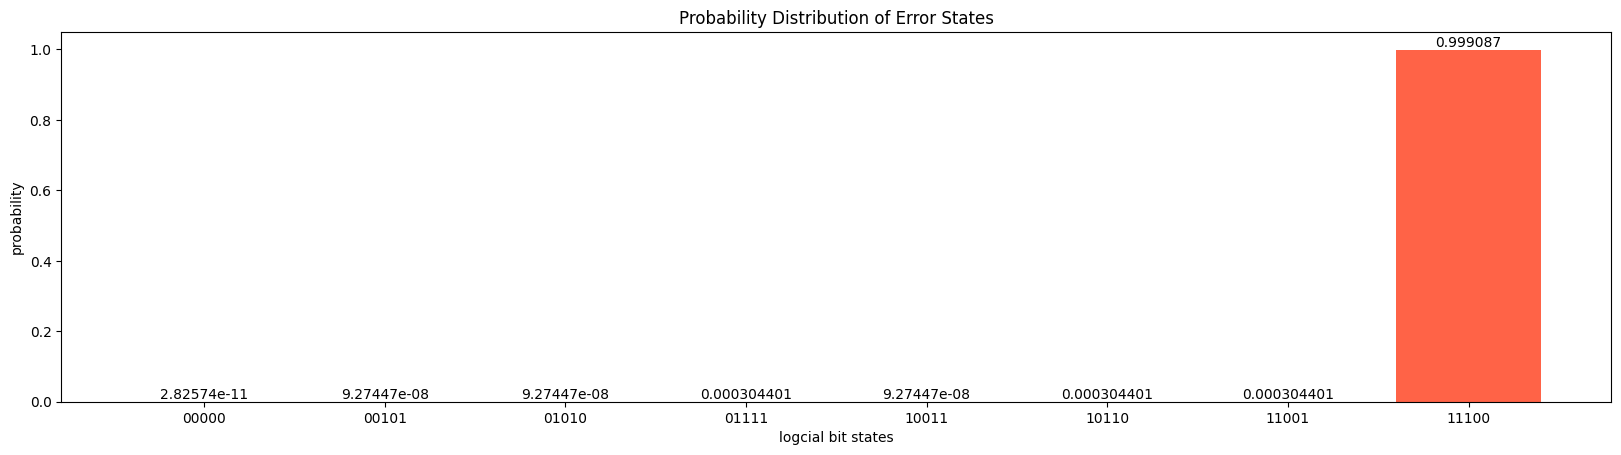

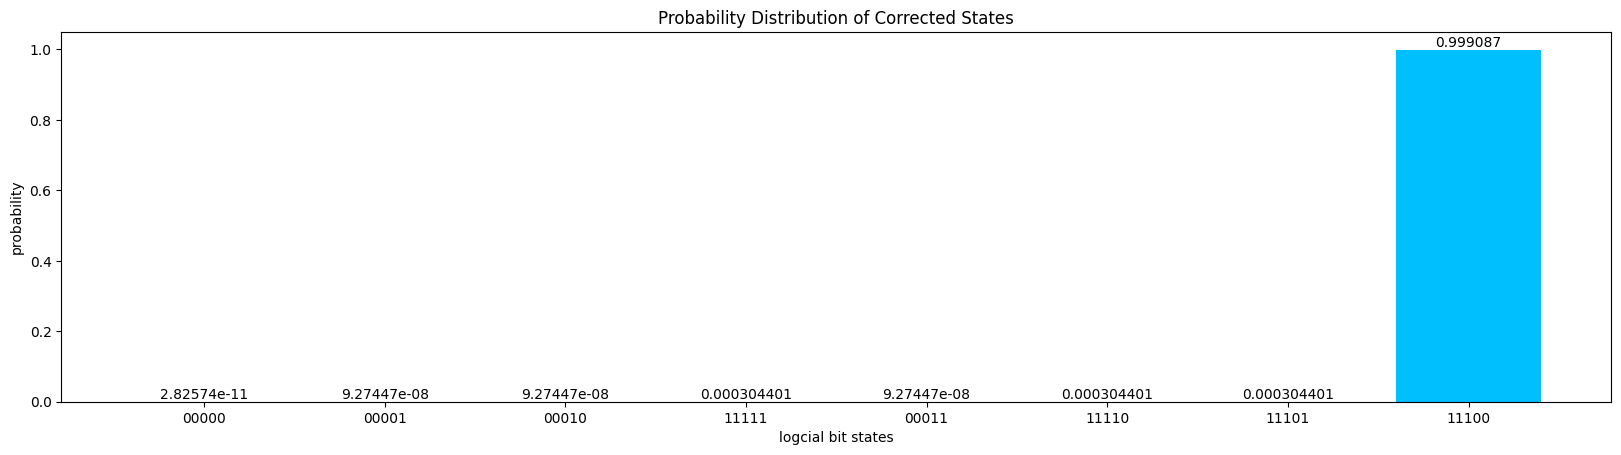

In [28]:
# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(error_logical_bits, np.abs(
    error_state)**2, label = 'Error States Distribution', color = 'tomato')
plt.title('Probability Distribution of Error States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

# Plotting the corrected state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
corrected_state_bars = ax.bar(corrected_bit_states, np.abs(
    corrected_states)**2, label = 'Corrected States Distribution', color = 'deepskyblue')
plt.title('Probability Distribution of Corrected States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(corrected_state_bars)
plt.show()

### Now to calculate the fidelities of our system

In [29]:
# Unencoded Fidelity:
F_unencoded = (np.cos(epsilon))**2

# Encoded Fidelity with no error detected:
F_no_error_detected = ((np.cos(epsilon))**6)/((np.cos(epsilon))**6 + (np.sin(epsilon))**6)
Prob_no_error_detected = (np.cos(epsilon))**6 + (np.sin(epsilon))**6

# Encoded Fidelity with error detected:
F_error_detected = (((np.cos(epsilon))**4)*(np.sin(epsilon))**2)/(((np.cos(epsilon))**4)*(np.sin(epsilon))**2 + ((np.sin(epsilon))**4)*(np.cos(epsilon))**2)
Prob_error_detected = 3*((np.cos(epsilon)**4 * (np.sin(epsilon))**2) + (np.sin(epsilon)**4 * (np.cos(epsilon))**2))

print('Unencoded Fidelity:   ', F_unencoded)
print('Encoded No Error Detected Fidelity: ', F_no_error_detected, ', with a probability of ', Prob_no_error_detected)
print('Encoded Error Detected Fidelity: ', F_error_detected, ', with a probability of ', Prob_error_detected)
print(' - - - - - - - - - -')
print('New Encoded Fidelity: ', F_no_error_detected*Prob_no_error_detected + F_error_detected*Prob_error_detected)

Unencoded Fidelity:    0.9996954135095479
Encoded No Error Detected Fidelity:  0.9999999999717167 , with a probability of  0.9990865188474343
Encoded Error Detected Fidelity:  0.9996954135095478 , with a probability of  0.000913481152565907
 - - - - - - - - - -
New Encoded Fidelity:  0.9999997217377244


### Extra resources that could be helpful

https://qiskit.org/documentation/stable/0.35/tutorials/circuits/3_summary_of_quantum_operations.html

https://www.oreilly.com/library/view/qiskit-pocket-guide/9781098112462/ch01.html

Fidelity:
https://www.frontiersin.org/articles/10.3389/fphy.2022.893507/full

General QEC:
http://theory.caltech.edu/~preskill/ph229/notes/chap7.pdf

### Attempting to 'detangle' the last 2 qubits so that we can see the new corrected logical state properly:
#### Method for uncoupling: https://quantumcomputing.stackexchange.com/questions/9648/unentangling-a-qubit-from-a-system-can-we-convert-alpha000-rangle-beta111
#### Measurement: https://inst.eecs.berkeley.edu/~cs191/fa14/lectures/lecture89.pdf

###  ---- Done by using masking technique ----